In [ ]:
import os
import itertools
from pathlib import Path
import random
from typing import Optional
import shutil

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras import Input
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import Colormap
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import kagglehub

In [2]:
gpu_info = !nvidia-smi
gpu_info = "\n".join(gpu_info)
if gpu_info.find("failed") >= 0:
  print("No GPU found.")
else:
  print(gpu_info)

Mon Oct 20 14:54:31 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   57C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
os.environ["PYTHONHASHSEED"] = "0"
random.seed(1254)
tf.random.set_seed(2)
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"

## Get Data & Image Preprocessing

In [4]:
path = kagglehub.dataset_download("brikwerk/bccd-white-blood-cell")
print("Path to dataset files:", path)

100%|██████████| 5.44M/5.44M [00:01<00:00, 4.17MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/brikwerk/bccd-white-blood-cell/versions/1


In [5]:
def make_dir(path: Path) -> None:
    path.mkdir(parents=True, exist_ok=True)


def split_dataset(
    base_dir: Path,
    output_base: Path = Path("dataset"),
    train_ratio: float=0.7,
    valid_ratio: float=0.15,
    test_ratio: float=0.15,
    seed=42
) -> None:
    random.seed(seed)

    class_dirs = [d for d in base_dir.iterdir() if d.is_dir()]

    for class_dir in class_dirs:
        class_name = class_dir.name
        print(f"\nClass: {class_name}")

        train_dir = output_base / "train" / class_name
        valid_dir = output_base / "valid" / class_name
        test_dir  = output_base / "test" / class_name
        for d in [train_dir, valid_dir, test_dir]:
            make_dir(d)

        images = [f for f in class_dir.iterdir() if f.is_file()]
        random.shuffle(images)

        n_total = len(images)
        n_train = int(train_ratio * n_total)
        n_valid = int(valid_ratio * n_total)
        n_test = n_total - n_train - n_valid

        train_files = images[:n_train]
        valid_files = images[n_train:n_train + n_valid]
        test_files  = images[n_train + n_valid:]

        print(f"{n_total} images: train={len(train_files)}, valid={len(valid_files)}, test={len(test_files)}")

        for fpath in train_files:
            shutil.copy(fpath, train_dir / fpath.name)
        for fpath in valid_files:
            shutil.copy(fpath, valid_dir / fpath.name)
        for fpath in test_files:
            shutil.copy(fpath, test_dir / fpath.name)

    print("\nData split done!")
    print(f"Results at: {os.path.abspath(output_base)}")

In [6]:
split_dataset(Path("/root/.cache/kagglehub/datasets/brikwerk/bccd-white-blood-cell/versions/1/bccd_wbc"))


Class: eosinophil
700 images: train=489, valid=105, test=106

Class: neutrophil
700 images: train=489, valid=105, test=106

Class: monocyte
700 images: train=489, valid=105, test=106

Class: lymphocyte
700 images: train=489, valid=105, test=106

Class: basophil
700 images: train=489, valid=105, test=106

Data split done!
Results at: /content/dataset


In [7]:
train_dir = Path("/content/dataset/train")
valid_dir = Path("/content/dataset/valid")
test_dir = Path("/content/dataset/test")

In [8]:
def plot_images() -> None:

  categories = ["basophil", "eosinophil", "lymphocyte", "monocyte", "neutrophil"]
  n_images = len(categories)

  fig, axes = plt.subplots(nrows=len(categories), ncols=n_images, figsize=(12, 12))
  fig.subplots_adjust(hspace=0.3, wspace=0.1)

  for i, category in enumerate(categories):
      category_path = os.path.join(train_dir, category)
      all_images = os.listdir(category_path)

      selected_images = random.sample(all_images, n_images)

      for j, img_name in enumerate(selected_images):
          img_path = os.path.join(category_path, img_name)
          img = mpimg.imread(img_path)

          axes[i, j].imshow(img)
          axes[i, j].axis("off")

      axes[i, 0].set_title(category, fontsize=14, loc="left", pad=10)

  plt.show()

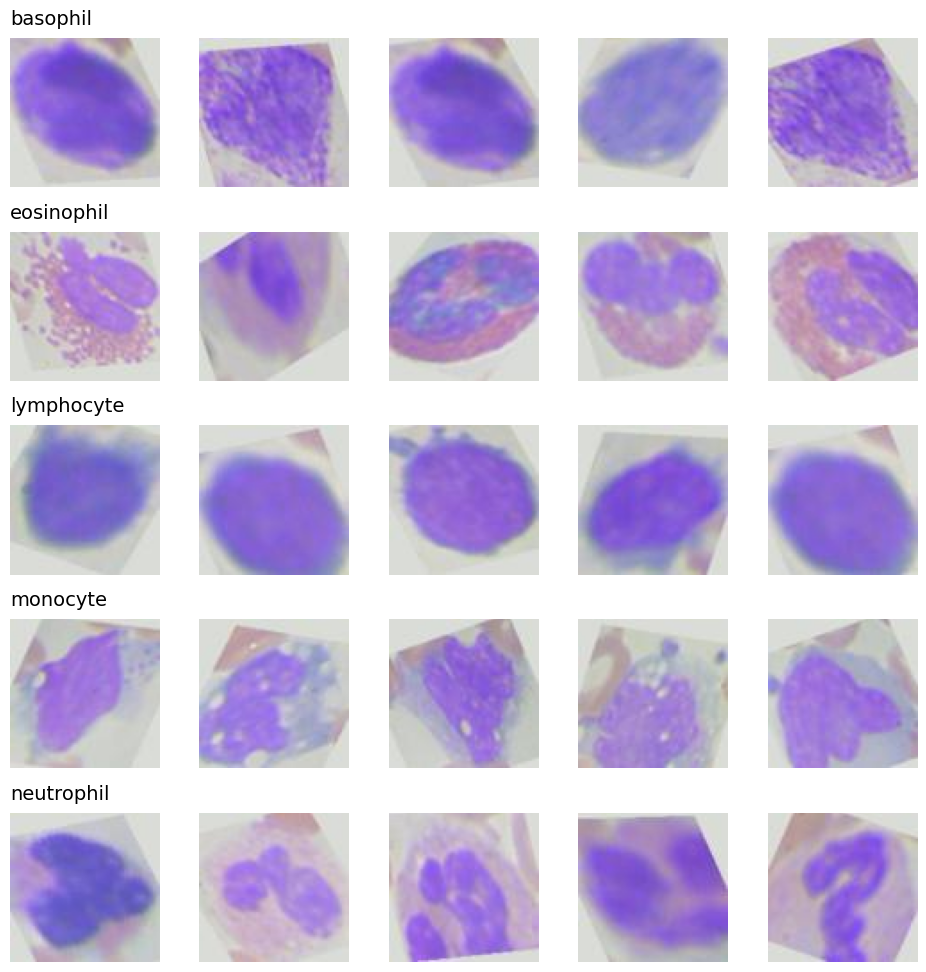

In [9]:
plot_images()

In [10]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

In [11]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    valid_dir,
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 2445 files belonging to 5 classes.
Found 525 files belonging to 5 classes.
Found 530 files belonging to 5 classes.


In [12]:
train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y))
val_ds = val_ds.map(lambda x, y: (preprocess_input(x), y))
test_ds = test_ds.map(lambda x, y: (preprocess_input(x), y))

In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

## Model

In [14]:
base_model = EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=IMG_SIZE + (3,)
)

for layer in base_model.layers:
    layer.trainable = False

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomZoom(0.2)
])

inputs = Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs)
x = base_model(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)

layer_sizes = [1024, 512, 256, 128, 64]
dropout_rate = 0.4

for size in layer_sizes:
    x = tf.keras.layers.Dense(size, activation="relu")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)

outputs = tf.keras.layers.Dense(5, activation="softmax")(x)

model = Model(inputs, outputs)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [15]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,066,856 (23.14 MB)

 Trainable params: 2,013,317 (7.68 MB)

 Non-trainable params: 4,053,539 (15.46 MB)

## Training

In [16]:
callbacks = [
    EarlyStopping(
        monitor="val_loss",
        patience=8,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=3
    ),
    ModelCheckpoint(
        "/content/blood_cell_model.keras",
        save_best_only=True,
        monitor="val_loss")
]

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

early_stopping = EarlyStopping(
    monitor="val_accuracy",
    patience=4,
    mode="max",
    restore_best_weights=True
)

In [17]:
epochs_ext = 30

history = model.fit(
    train_ds,
    epochs=epochs_ext,
    callbacks=callbacks + [early_stopping],
    validation_data=val_ds,
)

Epoch 1/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 33s 185ms/step - accuracy: 0.3500 - loss: 1.8588 - val_accuracy: 0.6514 - val_loss: 0.9489 - learning_rate: 0.0010
Epoch 2/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 9s 112ms/step - accuracy: 0.5615 - loss: 1.1461 - val_accuracy: 0.7619 - val_loss: 0.6265 - learning_rate: 0.0010
Epoch 3/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 108ms/step - accuracy: 0.6388 - loss: 0.9587 - val_accuracy: 0.7524 - val_loss: 0.6036 - learning_rate: 0.0010
Epoch 4/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 9s 114ms/step - accuracy: 0.7167 - loss: 0.7712 - val_accuracy: 0.8248 - val_loss: 0.4477 - learning_rate: 0.0010
Epoch 5/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 9s 113ms/step - accuracy: 0.7485 - loss: 0.6773 - val_accuracy: 0.8514 - val_loss: 0.3981 - learning_rate: 0.0010
Epoch 6/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 0.7564 - loss: 0.6607 - val_accuracy: 0.8648 - val_loss: 0.3556 - learning_rate: 0.0010
Epoch 7/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 9s 114ms/step - accuracy: 0.7629 - loss: 0.6118

## Plot Results

In [18]:
def plot_results(
    acc: list[float],
    val_acc: list[float],
    loss: list[float],
    val_loss: list[float]
) -> None:
    plt.figure(figsize=(10, 10))
    plt.subplot(2, 1, 1)
    plt.plot(acc, "b-", label="Training Accuracy")
    plt.plot(val_acc, "y-", label="Validation Accuracy")
    plt.legend(loc="lower right")
    plt.ylabel("Accuracy")
    plt.ylim([min(plt.ylim()), 1])
    plt.title("Training and Validation Accuracy")
    plt.grid(True)

    plt.subplot(2, 1, 2)
    plt.plot(loss, "b-", label="Training Loss")
    plt.plot(val_loss, "y-", label="Validation Loss")
    plt.legend(loc="upper right")
    plt.ylabel("Cross Entropy")
    plt.title("Training and Validation Loss")
    plt.xlabel("epoch")
    plt.grid(True)
    plt.show()

In [19]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

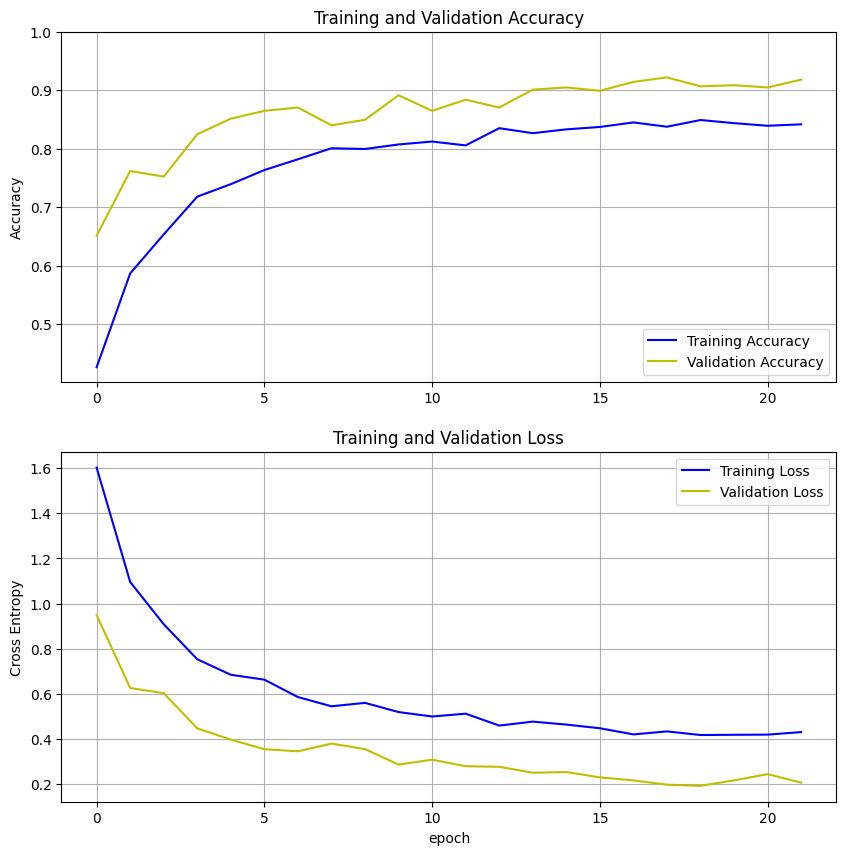

In [20]:
plot_results(acc, val_acc, loss, val_loss)

In [21]:
best_model = tf.keras.models.load_model("/content/blood_cell_model.keras")
predictions = best_model.predict(x=test_ds, verbose=1)

17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 241ms/step


In [22]:
def plot_confusion_matrix(
        cm: np.ndarray,
        classes: list[str],
        normalize: bool=True,
        title: str="Confusion Matrix",
        cmap: Optional[Colormap]=plt.cm.Blues
) -> None:
    plt.figure(figsize=(6, 6), facecolor="w", edgecolor="k")
    font = {
        "family": "DejaVu Sans",
        "weight": "bold",
        "size"  : 12
    }
    plt.rc("font", **font)
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized Confusion Matrix")
    else:
        print("Confusion Matrix without normalization")
    cm = np.around(cm, 4)
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    print(cm)
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    plt.tight_layout()
    plt.title(title)
    plt.ylabel("True label", fontsize=12)
    plt.xlabel("Predicted label\naccuracy={:0.4f}; misclass={:0.4f}".format(accuracy, misclass), fontsize=12)
    plt.show()

Normalized Confusion Matrix
[[1.     0.     0.     0.     0.    ]
 [0.     0.6792 0.     0.0094 0.3113]
 [0.     0.     0.9906 0.0094 0.    ]
 [0.     0.     0.0094 0.9906 0.    ]
 [0.     0.0189 0.     0.0189 0.9623]]


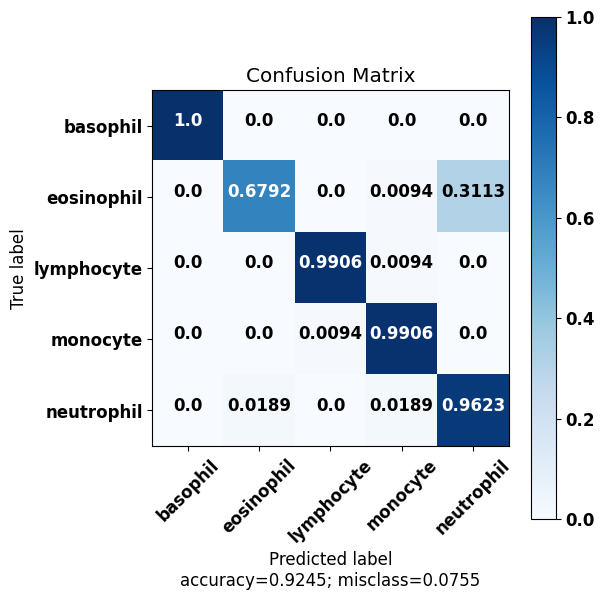

In [23]:
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred = np.argmax(predictions, axis=-1)
cm = confusion_matrix(y_true=y_true, y_pred=np.argmax(predictions, axis=-1))
cm_plot_labels = (["basophil", "eosinophil", "lymphocyte", "monocyte", "neutrophil"])
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title="Confusion Matrix")

In [24]:
print(classification_report(y_true, y_pred, target_names=cm_plot_labels))

              precision    recall  f1-score   support

    basophil       1.00      1.00      1.00       106
  eosinophil       0.97      0.68      0.80       106
  lymphocyte       0.99      0.99      0.99       106
    monocyte       0.96      0.99      0.98       106
  neutrophil       0.76      0.96      0.85       106

    accuracy                           0.92       530
   macro avg       0.94      0.92      0.92       530
weighted avg       0.94      0.92      0.92       530



In [25]:
def plot_roc_curve():
    y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3, 4])
    n_classes = y_true_bin.shape[1]

    plt.figure(figsize=(8,6))
    colors = ["blue", "red", "green", "orange", "yellow"]
    class_names = ["basophil", "eosinophil", "lymphocyte", "monocyte", "neutrophil"]

    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], predictions[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=colors[i], lw=2,
                 label="{} (AUC = {:0.2f})".format(class_names[i], roc_auc))

    plt.plot([0, 1], [0, 1], color="gray", lw=1, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Multi-Class ROC Curve")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

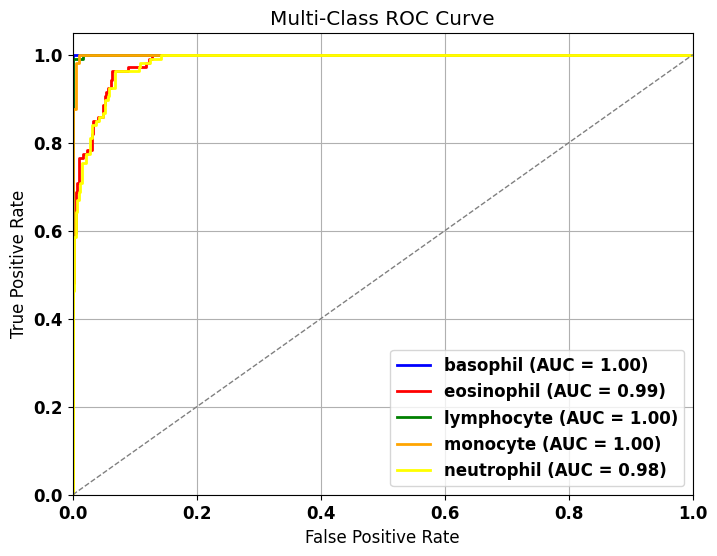

In [26]:
plot_roc_curve()